In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import torch
import diffusion_pde as dpde
from pathlib import Path
from scipy.io import loadmat

import matplotlib.pyplot as plt

In [2]:
data_dir = Path().cwd().parent / "data"
print("Data directory:", data_dir)

Data directory: c:\Users\Phill\Documents\School\MSc\4. Sem\Diffusion\dynamical-pde-diffusion\data


In [3]:
data_shape = (64, 64) # (h, w)
num_ch_a = 1
num_ch_u = 2
N = 100
num_tsteps = 50
label_dim = 3

t_steps = np.linspace(0, 1, num_tsteps)  # shape (T,)
labels = np.ones((N, label_dim))  # shape (N, label_dim)
init_cond = np.zeros((N, num_ch_a, *data_shape))  # shape (N, ch0, h, w)
data = np.zeros((N, num_ch_u, *data_shape, num_tsteps))  # shape (N, ch1, h, w, T)

dataset = dpde.datasets.DiffusionDataset(
    init_state=init_cond, 
    data=data, 
    t_steps=t_steps, 
    labels=labels
)

In [4]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=False)

X, label = next(iter(dataloader))
print("X shape:", X.shape, f"Expected shape: (2, {num_ch_a + num_ch_u}, {data_shape[0]}, {data_shape[1]})")  # Expected shape: (2, ch0 + ch1, h, w)
print("Label shape:", label.shape, f"Expected shape: (2, {label_dim + 1})")

X shape: torch.Size([10, 3, 64, 64]) Expected shape: (2, 3, 64, 64)
Label shape: torch.Size([10, 4]) Expected shape: (2, 4)


In [5]:
chs = [num_ch_a + num_ch_u, 32, 64, 128, 256]

unet = dpde.models.Unet(chs, label_ch=label_dim + 1)
edm_model = dpde.models.EDMWrapper(unet)
loss = dpde.models.EDMLoss()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
edm_model = edm_model.to(device)

device: cuda


In [10]:
wandb_kwargs = {
    "entity": "philiphohwy-danmarks-tekniske-universitet-dtu",
    "project": "dynamical-pde-diffusion",
    "name": "test-run2",
    "tags": ["testing", "unet", "edm"],
    "notes": "This is a test run to check if the training loop works.",
}

In [11]:
dpde.training.train(
    model=edm_model,
    dataloader=dataloader,
    loss_fn=loss,
    device=device,
    epochs=5,
    lr=1e-4,
    weight_decay=0.0,
    wandb_kwargs=wandb_kwargs
)

wandb: Currently logged in as: philiphohwy (philiphohwy-danmarks-tekniske-universitet-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loss/train/epoch,▁█▁▃▃
Loss/train/epoch,6.2038


In [3]:
#data = np.load(data_dir / "heat_eq_data_1000_64_64_32_0_10.npz")
data = np.load(data_dir / "heat_eq_data_1000_64_64_64_0_20.npz")

In [4]:
U = data['U']  # shape (N, ch1, h, w, T)
A = data['A']  # shape (N, ch0, h, w)
t_steps = data['t_steps']  # shape (T,)
labels = data['labels']  # shape (N, label_dim)

print(U.shape)  # Expected shape: (N, ch1, h, w, T)
print(A.shape)  # Expected shape: (N, ch0, h, w)
print(t_steps.shape)  # Expected shape: (T,)
print(labels.shape)  # Expected shape: (N, label_dim)

(1000, 1, 64, 64, 65)
(1000, 1, 64, 64)
(65,)
(1000,)


U min: -0.6930708885192871, max: 0.4760628342628479


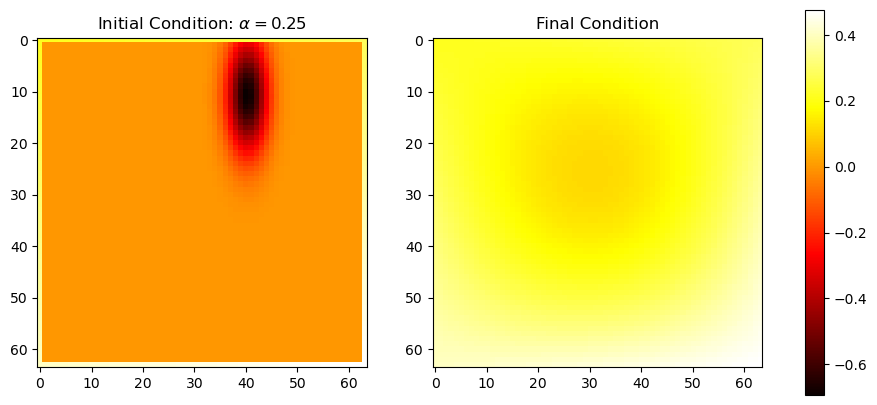

In [10]:
idx = 0
vmin, vmax = U[idx].min(), U[idx].max()
print(f"U min: {vmin}, max: {vmax}")
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
axs[0].imshow(U[idx, 0, :, :, 0], cmap='hot', vmin=vmin, vmax=vmax)
axs[0].set_title(f'Initial Condition: $\\alpha={labels[idx]:.2f}$')
axs[1].imshow(U[idx, 0, :, :, -1], cmap='hot', vmin=vmin, vmax=vmax)
axs[1].set_title('Final Condition')
fig.colorbar(axs[1].images[0], ax=axs, orientation='vertical', fraction=.1)
plt.show()

In [6]:
diff = U[..., 1:] - U[..., :-1]
diff = np.permute_dims(diff, (0, 4, 1, 2, 3)).squeeze()  # shape (N, T-1, h, w)
norm_diff = np.linalg.norm(diff.reshape(diff.shape[0], diff.shape[1], -1), axis=-1)  # shape (N, T-1)
mean_norm_diff = norm_diff.mean(axis=0)  # shape (T-1,)
print(diff.shape)
print(norm_diff.shape)
print(mean_norm_diff.shape)


(1000, 64, 64, 64)
(1000, 64)
(64,)


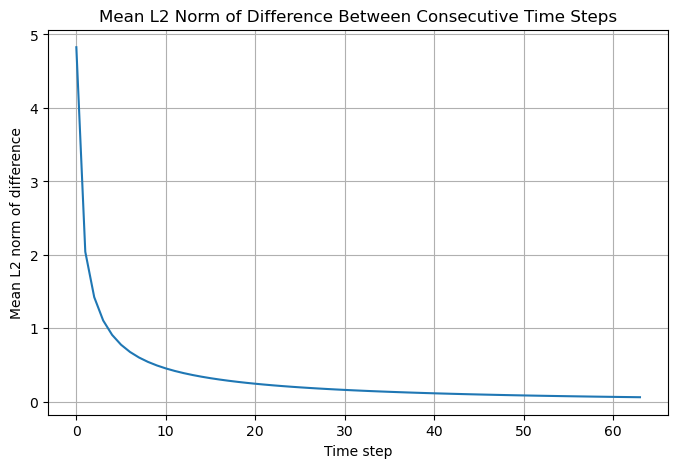

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(mean_norm_diff)
#plt.plot(norm_diff[:10].T)
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Time step')
plt.ylabel('Mean L2 norm of difference')
plt.title('Mean L2 Norm of Difference Between Consecutive Time Steps')
plt.grid(True)
plt.show()